In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import datetime as dt
import pandas_datareader as web



from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


In [2]:
index = '^STOXX50E'
start_train = dt.datetime(2007,7,1)
end_train = dt.datetime(2017,7,1)

#data for training
data_train = web.DataReader(index, 'yahoo',start_train,end_train) 

start_test = dt.datetime(2017,7,2)
end_test = dt.datetime(2021,5,1)

#data for testing
data_test = web.DataReader(index, 'yahoo',start_test,end_test)

#data_train.tail()

In [3]:
#get the daily change in percent
data_train['Change'] = data_train['Close'].pct_change()

In [4]:
#reset index and get date as individual column
data_train.reset_index(inplace=True)

In [5]:
#split the date down to month+year
data_train['mdate'] = data_train['Date'].dt.to_period('M')

In [6]:
data_train['ProdChange'] = data_train['Change'] +1
#data_train

In [7]:
group = data_train.groupby(['mdate'])

In [8]:
data_train['Month'] = data_train['Date'].dt.month

In [9]:
data_train['mChange'] = group['ProdChange'].transform(np.product) -1

In [10]:
#data_train

In [11]:
## Monatliche relative Änderungen in einem individuellen DF

In [12]:
monthlyChange = data_train[['Month','mChange']]
test = monthlyChange.drop_duplicates()

In [13]:
test

,Month,mChange
0,7,-0.034577
22,8,-0.004896
44,9,0.020293
64,10,0.024666
87,11,-0.021123
...,...,...
2403,2,0.027527
2423,3,0.054621
2446,4,0.016756
2464,5,-0.001405


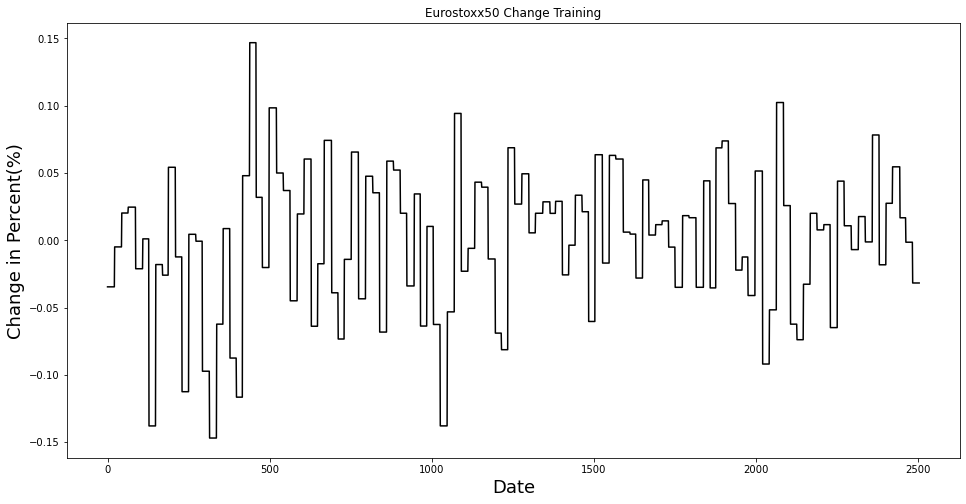

In [14]:
plt.figure(figsize=(16,8))
plt.title('Eurostoxx50 Change Training')
plt.plot(monthlyChange['mChange'], color = 'black')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

In [15]:
#do the same with testing data

data_test['Change'] = data_test['Close'].pct_change()
data_test.reset_index(inplace=True)
data_test['mdate'] = data_test['Date'].dt.to_period('M')
data_test['ProdChange'] = data_test['Change'] +1
data_test['Month'] = data_test['Date'].dt.month
group_testing = data_test.groupby(['mdate'])
data_test['mChange'] = group_testing['ProdChange'].transform(np.product) -1

monthlyChange_testing = data_test[['Month','mChange']]
monthlyChange_testing = monthlyChange_testing.drop_duplicates()

In [ ]:
#monthlyChange_testing

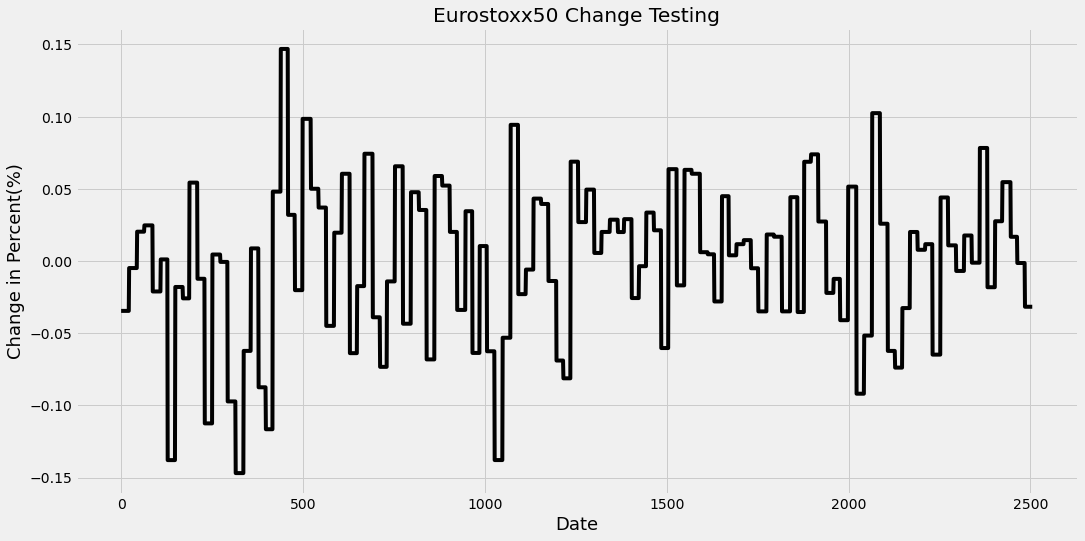

In [16]:
plt.figure(figsize=(16,8))
plt.title('Eurostoxx50 Change Testing')
plt.plot(monthlyChange['mChange'], color = 'black')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

In [17]:
y_train = monthlyChange['mChange']
X_train = monthlyChange[['Month']]

In [18]:
y_train

0      -0.034577
1      -0.034577
2      -0.034577
3      -0.034577
4      -0.034577
          ...   
2501   -0.031708
2502   -0.031708
2503   -0.031708
2504   -0.031708
2505   -0.031708
Name: mChange, Length: 2506, dtype: float64

In [41]:
y_test = monthlyChange_testing['mChange']
X_test = monthlyChange_testing[['Month']]

In [20]:
X_test

,Month
0,7
21,8
43,9
64,10
86,11
108,12
127,1
148,2
168,3
189,4


In [21]:

lr_model=LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [22]:
y_pred=lr_model.predict(X_test)
y_pred

array([-1.68581802e-05,  8.91104050e-04,  1.79906628e-03,  2.70702851e-03,
        3.61499074e-03,  4.52295297e-03, -5.46463156e-03, -4.55666933e-03,
       -3.64870710e-03, -2.74074487e-03, -1.83278264e-03, -9.24820411e-04,
       -1.68581802e-05,  8.91104050e-04,  1.79906628e-03,  2.70702851e-03,
        3.61499074e-03,  4.52295297e-03, -5.46463156e-03, -4.55666933e-03,
       -3.64870710e-03, -2.74074487e-03, -1.83278264e-03, -9.24820411e-04,
       -1.68581802e-05,  8.91104050e-04,  1.79906628e-03,  2.70702851e-03,
        3.61499074e-03,  4.52295297e-03, -5.46463156e-03, -4.55666933e-03,
       -3.64870710e-03, -2.74074487e-03, -1.83278264e-03, -9.24820411e-04,
       -1.68581802e-05,  8.91104050e-04,  1.79906628e-03,  2.70702851e-03,
        3.61499074e-03,  4.52295297e-03, -5.46463156e-03, -4.55666933e-03,
       -3.64870710e-03, -2.74074487e-03])

In [35]:
#y_test['predicted'] = y_pred 
#fügt am ende das array hinzu als neues wert


In [42]:
print(len(y_test))
print(len(y_pred))

testing = y_test.values


46
46


In [43]:
testing

array([-0.012157  , -0.0080856 ,  0.05067416,  0.02200366, -0.02831286,
       -0.01847935,  0.0300603 , -0.04719213, -0.02252424,  0.05206605,
       -0.03672257, -0.0032436 ,  0.03825241, -0.03760898,  0.00185683,
       -0.05933453, -0.00762472, -0.05880625,  0.05789324,  0.0439415 ,
        0.0162055 ,  0.04860509, -0.06663314,  0.05891301, -0.00196904,
       -0.01156384,  0.0416399 ,  0.00979422,  0.02751356,  0.01212068,
       -0.02869439, -0.08553354, -0.16296493,  0.05060463,  0.04175989,
        0.06028133, -0.01847517,  0.03093259, -0.0241099 , -0.07370973,
        0.18062615,  0.02263397, -0.0252409 ,  0.04452181,  0.07776012,
        0.01416868])

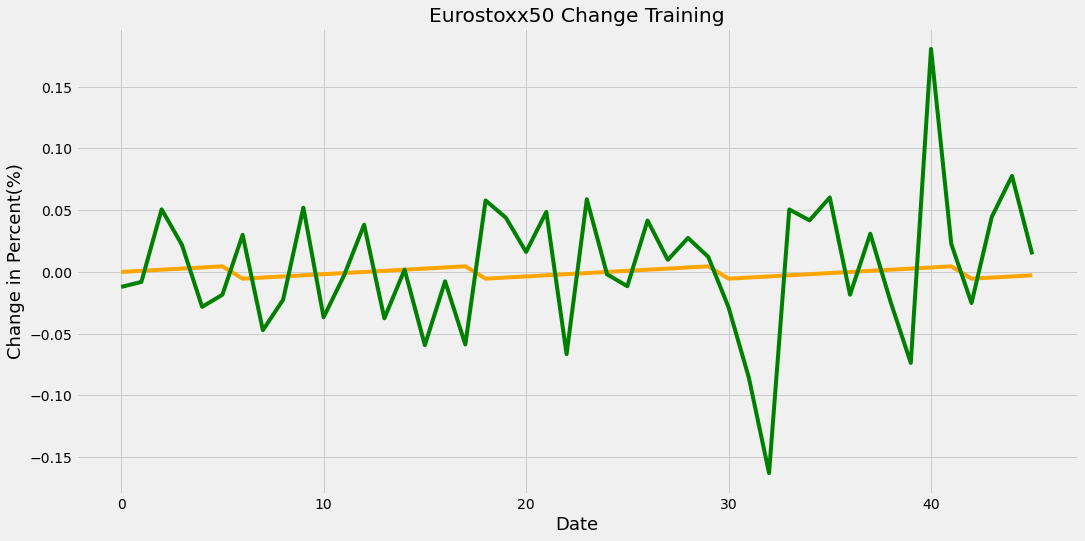

In [44]:
plt.figure(figsize=(16,8))
plt.title('Eurostoxx50 Change Training')
plt.plot(y_pred, color = 'orange')
plt.plot(testing, color = 'green')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()